In [1]:
from starlette.applications import Starlette
from starlette.responses import JSONResponse, HTMLResponse, RedirectResponse
from fastai.vision import (
    ImageDataBunch,
    Learner,
    load_learner,
    open_image,
    get_transforms,
    models,
    defaults
)
# from fastai.vision import *
import torch
from pathlib import Path
from io import BytesIO
import sys
import uvicorn
import aiohttp
import asyncio
import numpy as np
import os

In [2]:
defaults.device = torch.device('cpu')

In [3]:
mini_learner = load_learner(".", "export.pkl")

/Users/lindsayedwards/anaconda3/envs/starlette/lib/python3.7/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


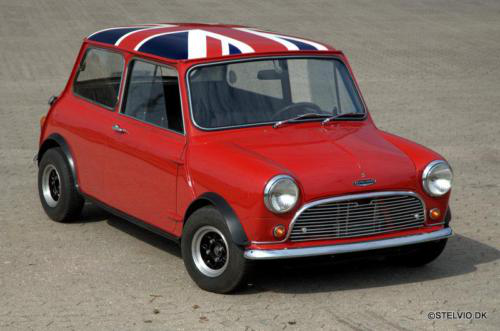

In [4]:
img = open_image("data/old_mini/10. 124_old_mini_cooper_vintage_83313.jpeg")
img

In [5]:
pred_class,pred_idx,outputs = mini_learner.predict(img)
pred_class

Category old_mini

In [6]:
pred_class.obj

'old_mini'

In [7]:
async def get_bytes(url):
    async with aiohttp.ClientSession() as session:
        async with session.get(url) as response:
            return await response.read()

In [8]:
app = Starlette()

In [9]:
classes = ["a new mini", "an old mini"]

In [10]:
classes[pred_idx.item()]

'an old mini'

In [11]:
@app.route("/upload", methods=["POST"])
async def upload(request):
    data = await request.form()
    bytes = await (data["file"].read())
    prediction = predict_image_from_bytes(bytes)
    return   HTMLResponse(create_response_page(prediction))

@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    prediction = predict_image_from_bytes(bytes)
    return   HTMLResponse(create_response_page(prediction))

def predict_image_from_bytes(bytes):
    classes = ["a new mini", "an old mini"]
    img = open_image(BytesIO(bytes))
    _, pred_idx, _ = mini_learner.predict(img)
    return classes[pred_idx.item()]

def create_response_page(prediction):
    page_contents = """
    Classification succesful!
    <h4>It's """ +  prediction + "!\n<br>" + """
        </form>
        <form action="/">
            <input type="submit" value="Return to main page" />
        </form>
        """
    return page_contents
    
    
    
    
#     return JSONResponse({
#         "predictions": sorted(
#             zip(mini_learner.data.classes, map(float, losses)),
#             key=lambda p: p[1],
#             reverse=True
#         )
#     })

@app.route("/")
def form(request):
    return HTMLResponse(
        """
        <h1>Mini classifier</h1>
        <form action="/upload" method="post" enctype="multipart/form-data">
            Select image to upload:
            <input type="file" name="file">
            <input type="submit" value="Upload Image">
        </form>
        Or submit a URL:
        <form action="/classify-url" method="get">
            <input type="url" name="url">
            <input type="submit" value="Fetch and analyze image">
        </form>
    """)

@app.route("/form")
def redirect_to_homepage(request):
    return RedirectResponse("/")

# if __name__ == "__main__":
#     if "serve" in sys.argv:
#         uvicorn.run(app, host="0.0.0.0", port=8008)

In [12]:
uvicorn.run(app, host="0.0.0.0", port=8008)

RuntimeError: This event loop is already running

INFO: Started server process [50372]
INFO: Waiting for application startup.
INFO: Uvicorn running on http://0.0.0.0:8008 (Press CTRL+C to quit)
INFO: ('127.0.0.1', 64699) - "GET / HTTP/1.1" 200
INFO: ('127.0.0.1', 64699) - "GET /classify-url HTTP/1.1" 200
INFO: ('127.0.0.1', 64699) - "GET / HTTP/1.1" 200


In [ ]:
bytes = await get_bytes(request.query_params[""])